In [1]:
from data_utils import get_prepared_data
import pandas as pd

# df = get_prepared_data(shuffle=False)

# df.to_csv('prepared_data_no_shuffle.csv', index=False) 
df = pd.read_csv('prepared_data.csv')  

In [2]:
df["gender"] = (df["gender"] == "F")
df = df.drop("participationStartDate", axis=1)
df

,bpm,pcode,bpm-1min,bpm-5min,bpm-10min,temperature,temperature-1min,temperature-5min,temperature-10min,brightness,...,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ
0,61.0,P55,56.0,63.0,61.0,32.770000,33.090000,32.730000,32.310001,3374.0,...,20,True,15,10,10,9,10,9,1,5
1,75.0,P40,67.0,70.0,70.0,34.209999,34.009998,33.570000,33.160000,0.0,...,28,False,7,12,6,7,11,16,2,4
2,75.0,P10,80.0,76.0,69.0,32.840000,32.810001,32.840000,32.639999,155.0,...,25,False,6,7,9,9,11,13,1,3
3,79.0,P12,87.0,80.0,75.0,32.200001,32.259998,32.310001,32.110001,25.0,...,20,False,9,12,7,7,12,14,6,4
4,65.0,P16,60.0,72.0,64.0,34.130001,34.110001,34.360001,34.139999,91.0,...,24,False,14,8,6,4,13,6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,90.0,P60,92.0,78.0,75.0,33.139999,33.160000,33.189999,33.119999,250.0,...,20,False,15,10,4,6,13,16,8,11
1300,65.0,P55,64.0,59.0,57.0,33.060001,33.150002,32.560001,32.240002,3128.0,...,20,True,15,10,10,9,10,9,1,5
1301,76.0,P09,75.0,73.0,72.0,31.719999,31.410000,31.969999,31.809999,0.0,...,19,True,12,12,4,11,9,30,19,16
1302,71.0,P12,73.0,74.0,77.0,29.600000,29.500000,29.559999,29.950001,18.0,...,20,False,9,12,7,7,12,14,6,4


**Split into train and test sets**

In [3]:
from sklearn.model_selection import train_test_split
import random

pcodes = list(set(df["pcode"]))
test_pcodes = set([random.choice(pcodes) for _ in range(int(0.07*len(pcodes)))])

test_pcodes_df = df[df["pcode"].isin(test_pcodes)]
df =  df[~df["pcode"].isin(test_pcodes)]

df = df.drop("pcode", axis=1)
test_pcodes_df = test_pcodes_df.drop("pcode", axis=1)

y_columns = ['valence', 'arousal', 'attention', 'stress']
X = df.drop(y_columns, axis=1)
y = df[y_columns]

X_test_pcodes = test_pcodes_df.drop(y_columns, axis=1)
y_test_pcodes = test_pcodes_df[y_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, shuffle=False)

X_test = pd.concat([X_test, X_test_pcodes], ignore_index=True)
y_test = pd.concat([y_test, y_test_pcodes], ignore_index=True)

In [4]:
test_pcodes

{'P13', 'P21', 'P22', 'P70'}

In [5]:
len(X_test), len(X_train)

(336, 968)

In [6]:
import numpy as np
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from model_utils import get_metrics, plot_model_comparison, print_averages, plot_confusion_matricies, get_cv_metrics, print_cv_metrics, get_grid_search, get_grid_search_cv_metrics

In [7]:
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

**Logistic Regression**

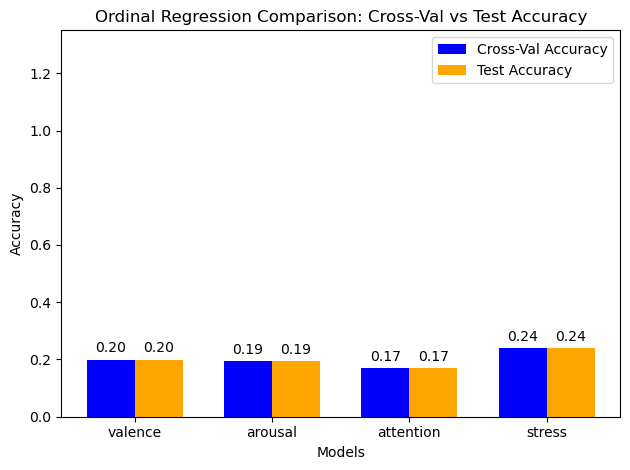

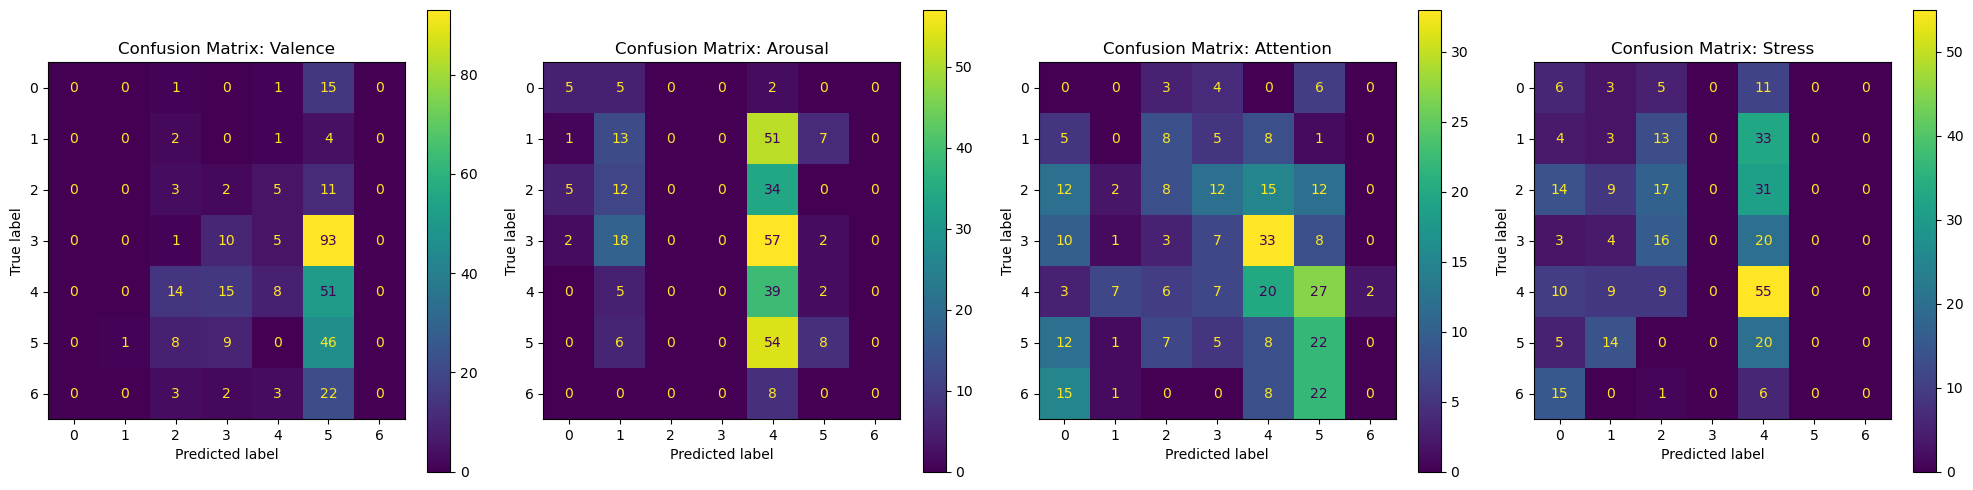

Cross-Val Accuracy: 0.2430385663159019 += 0.03492429477841644
Cross-Val F1: 0.18538078021308374 += 0.04425466750101256
Cross-Val Precision: 0.2046528862768839 += 0.06133611845487386
Cross-Val Recall: 0.2430385663159019 += 0.03492429477841644
Cross-Val AUC: 0.567871400479587 += 0.021443342567804665
Test Accuracy: 0.20089285714285715
Test F1: 0.15301987670404513
Test Precision: 0.1746982240082508
Test Recall: 0.20089285714285715
Test AUC: 0.5340397410544719


In [8]:
from mord import LogisticIT  

ordinal_train_acc = []
ordinal_test_acc = []
ordinal_cms = []
ordinal_metrics = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    
    ordinal_model = LogisticIT()

    cv_metrics = get_cv_metrics(ordinal_model, X_train, y_train[target], X_test, y_test[target], cv=5)

    test_preds = ordinal_model.predict(X_test)

    ordinal_cms.append(cv_metrics["test_cm"])
    ordinal_metrics.append(cv_metrics)

    ordinal_train_acc.append(cv_metrics['test_accuracy'])
    ordinal_test_acc.append(accuracy_score(y_test[target], test_preds))

plot_model_comparison("Ordinal Regression", y_columns, ordinal_test_acc, ordinal_train_acc)
plot_confusion_matricies(ordinal_cms, y_columns)
print_cv_metrics(ordinal_metrics)



**AdaBoost Classifier**

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Fitting 10 folds for each of 16 candidates, totalling 160 fits


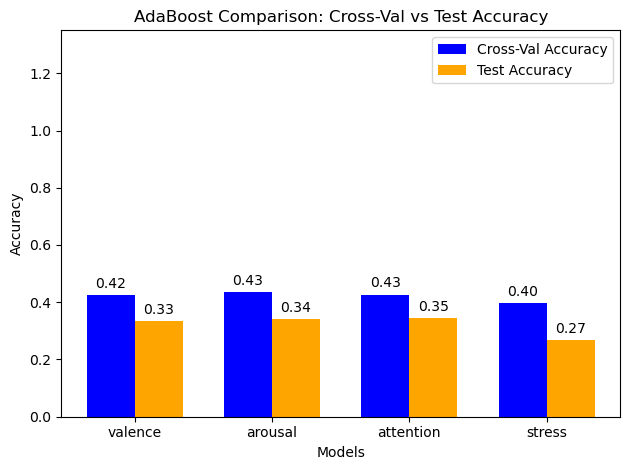

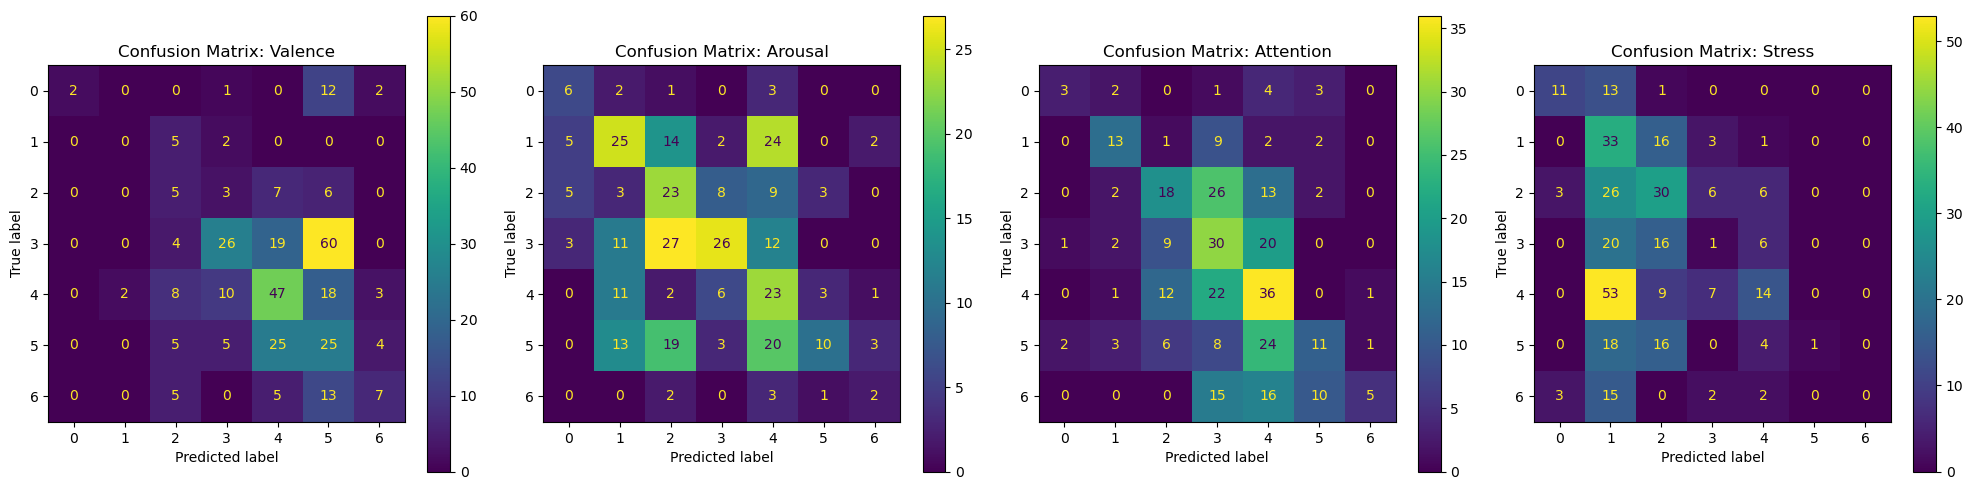

Cross-Val Accuracy: 0.42046284364261166 += 0.05407476979670603
Cross-Val F1: 0.4065561788011048 += 0.0561993198551865
Cross-Val Precision: 0.43436303485869554 += 0.06624127820917664
Cross-Val Recall: 0.42046284364261166 += 0.05407476979670603
Cross-Val AUC: 0.7400912553298404 += 0.029034575849483775
Test Accuracy: 0.32217261904761907
Test F1: 0.30957751099387004
Test Precision: 0.41338065224171094
Test Recall: 0.32217261904761907
Test AUC: 0.677840414021744
Ideal Parameters {'learning_rate': 0.2, 'n_estimators': 100}


In [12]:
from mord import LogisticIT  
from sklearn.ensemble import AdaBoostClassifier

ada_train_acc = []
ada_test_acc = []
ada_metrics = []
ada_cms = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        "learning_rate": [0.2, 0.6, 1, 1.3]
    }
    
    ada_model = AdaBoostClassifier()
    grid_search = get_grid_search(ada_model, param_grid)
    grid_search.fit(X_train, y_train[target])
    
    test_preds = grid_search.best_estimator_.predict(X_test)
    ada_model = grid_search.best_estimator_

    cv_metrics = get_grid_search_cv_metrics(grid_search, X_test, y_test[target])
    ada_metrics.append(cv_metrics)

    ada_cms.append(cv_metrics["test_cm"])

    ada_train_acc.append(cv_metrics['crossval_accuracy'])
    ada_test_acc.append(accuracy_score(y_test[target], test_preds))

plot_model_comparison("AdaBoost", y_columns, ada_test_acc, ada_train_acc)
plot_confusion_matricies(ada_cms, y_columns)
print_cv_metrics(ada_metrics)
print("Ideal Parameters", grid_search.best_params_)

**GradientBoost Classifier**

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits


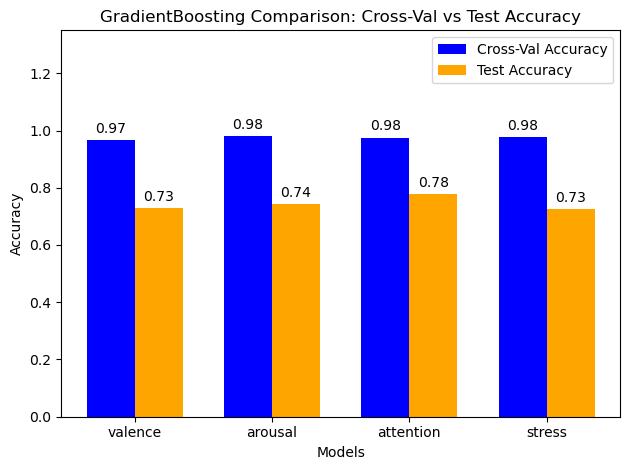

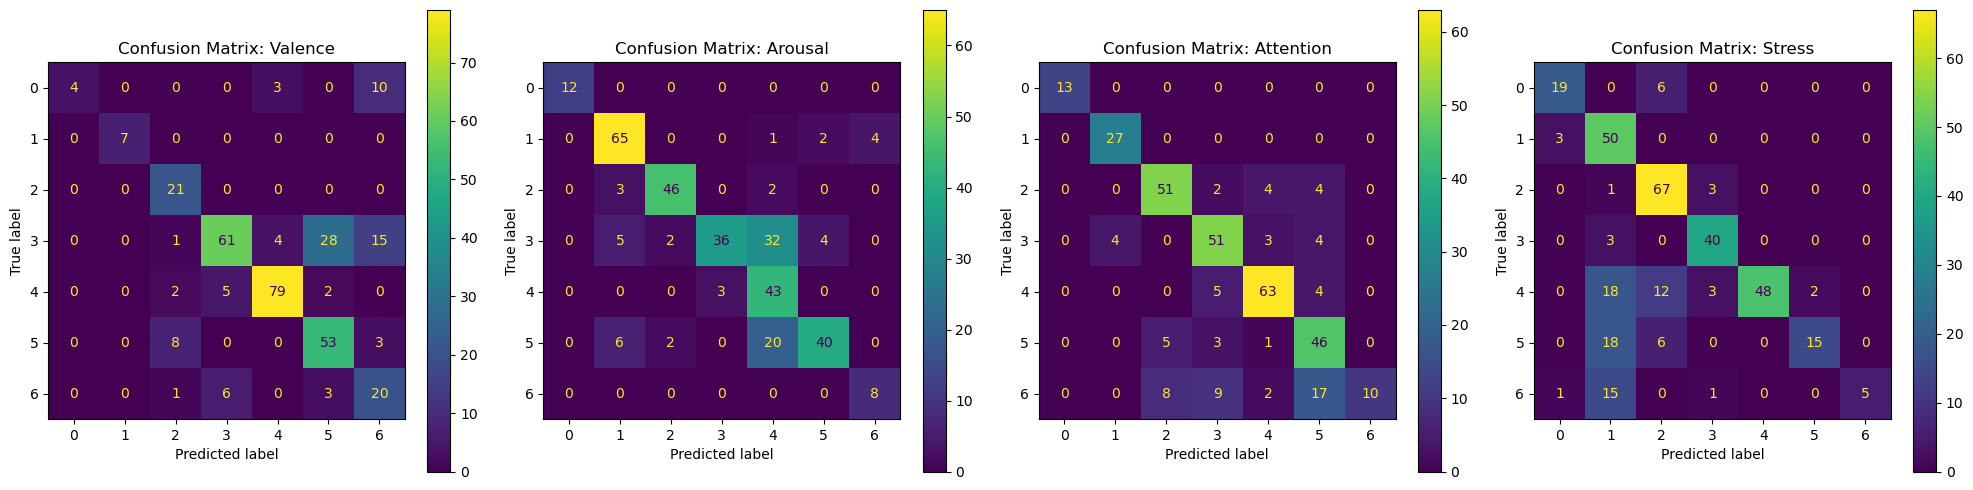

Cross-Val Accuracy: 0.974940936426117 += 0.014584957993843652
Cross-Val F1: 0.9740455476929288 += 0.015591987878190789
Cross-Val Precision: 0.9766948264298333 += 0.013545223299955056
Cross-Val Recall: 0.974940936426117 += 0.014584957993843652
Cross-Val AUC: 0.9977422148852662 += 0.0026004933033359455
Test Accuracy: 0.7440476190476191
Test F1: 0.7350653154493161
Test Precision: 0.8069648134239644
Test Recall: 0.7440476190476191
Test AUC: 0.9538940317648357
Ideal Parameters {'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [13]:
from sklearn.ensemble import GradientBoostingClassifier

gb_train_acc = []
gb_test_acc = []
gb_metrics = []
gb_cms = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    param_grid = {
    'n_estimators': [50, 100, 200],        
    # 'learning_rate': [0.01, 0.1, 0.2],     
    'max_depth': [3, 5, 7],                
    # 'min_samples_split': [2, 5, 10],       
    # 'min_samples_leaf': [1, 2, 4],         
    'subsample': [0.6, 0.8, 1.0],          
    # 'max_features': ['sqrt', 'log2', None] 
}
    
    gb_model = GradientBoostingClassifier()
    grid_search = get_grid_search(gb_model, param_grid)
    grid_search.fit(X_train, y_train[target])
    
    test_preds = grid_search.best_estimator_.predict(X_test)
    gb_model = grid_search.best_estimator_

    cv_metrics = get_grid_search_cv_metrics(grid_search, X_test, y_test[target])
    gb_metrics.append(cv_metrics)

    gb_cms.append(cv_metrics["test_cm"])

    gb_train_acc.append(cv_metrics['crossval_accuracy'])
    gb_test_acc.append(accuracy_score(y_test[target], test_preds))

plot_model_comparison("GradientBoosting", y_columns, gb_test_acc, gb_train_acc)
plot_confusion_matricies(gb_cms, y_columns)
print_cv_metrics(gb_metrics)
print("Ideal Parameters", grid_search.best_params_)


**Naive Bayes Classifier**

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


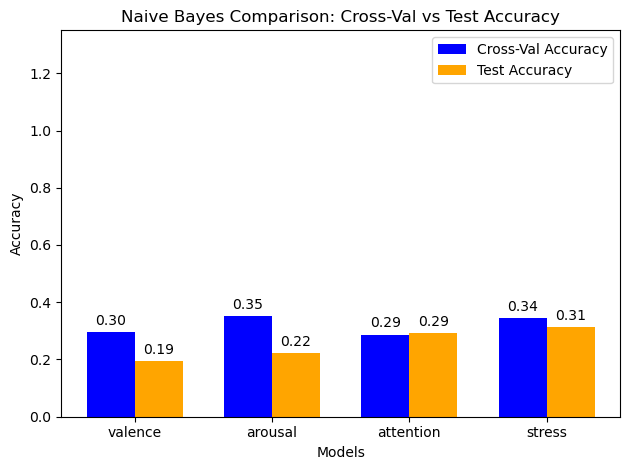

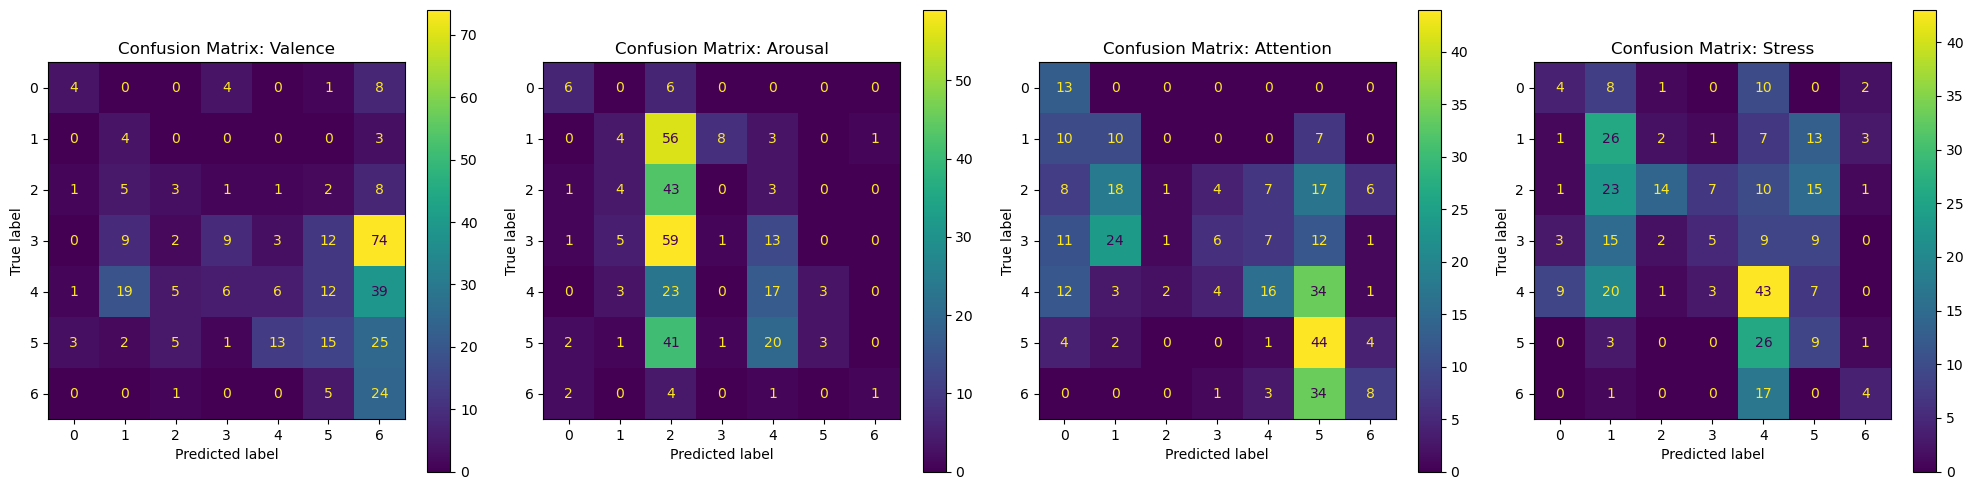

Cross-Val Accuracy: 0.31950977233676975 += 0.04173062144602996
Cross-Val F1: 0.29031634587997524 += 0.049127634639434564
Cross-Val Precision: 0.4179337807600126 += 0.08540496450359505
Cross-Val Recall: 0.31950977233676975 += 0.04173062144602996
Cross-Val AUC: 0.7069718703033638 += 0.028939753527850675
Test Accuracy: 0.25520833333333337
Test F1: 0.2158841025876555
Test Precision: 0.32853914189802846
Test Recall: 0.25520833333333337
Test AUC: 0.6489319528819345
Ideal Parameters {}


In [14]:
from sklearn.naive_bayes import GaussianNB

nb_train_acc = []
nb_test_acc = []
nb_metrics = []
nb_cms = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    param_grid = {}
    
    nb_model = GaussianNB()
    grid_search = get_grid_search(nb_model, param_grid)
    grid_search.fit(X_train, y_train[target])
    
    test_preds = grid_search.best_estimator_.predict(X_test)
    nb_model = grid_search.best_estimator_

    cv_metrics = get_grid_search_cv_metrics(grid_search, X_test, y_test[target])
    nb_metrics.append(cv_metrics)

    nb_cms.append(cv_metrics["test_cm"])

    nb_train_acc.append(cv_metrics['crossval_accuracy'])
    nb_test_acc.append(accuracy_score(y_test[target], test_preds))

plot_model_comparison("Naive Bayes", y_columns, nb_test_acc, nb_train_acc)
plot_confusion_matricies(nb_cms, y_columns)
print_cv_metrics(nb_metrics)
print("Ideal Parameters", grid_search.best_params_)



**Random Forest Classifier**

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits


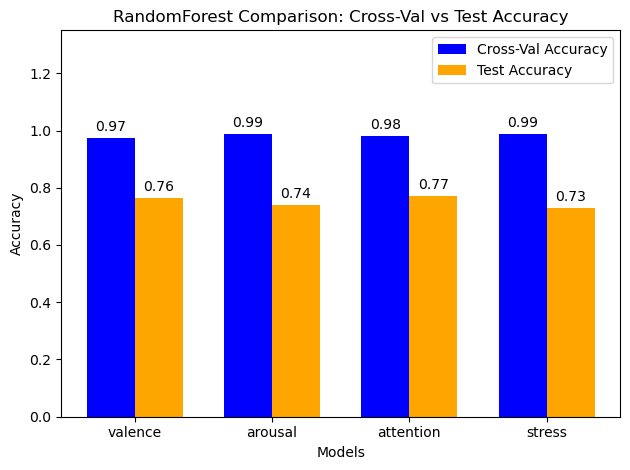

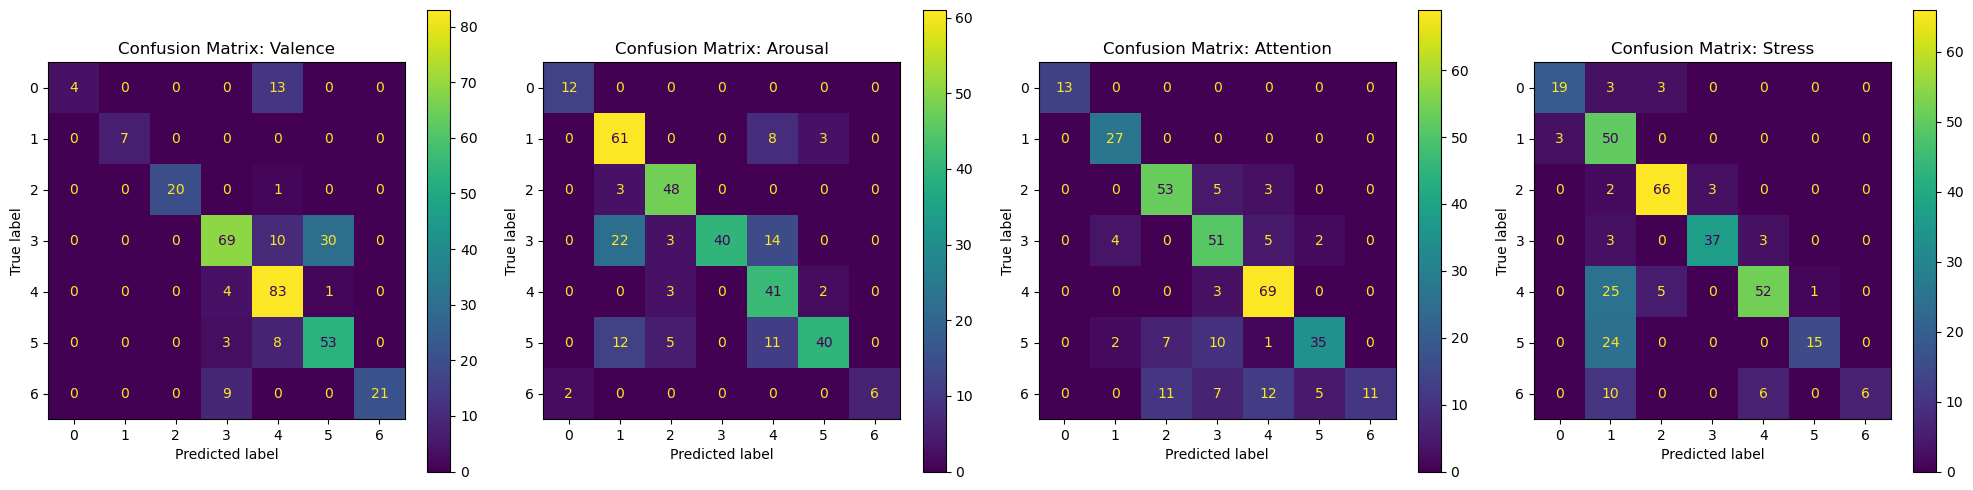

Cross-Val Accuracy: 0.9826863187285224 += 0.011732764502962118
Cross-Val F1: 0.9822228418998336 += 0.012250549634839833
Cross-Val Precision: 0.9838491479267465 += 0.01078235590502127
Cross-Val Recall: 0.9826863187285224 += 0.011732764502962118
Cross-Val AUC: 0.9984253010354834 += 0.0023406399297848115
Test Accuracy: 0.7507440476190476
Test F1: 0.7415911401924137
Test Precision: 0.8056711065822773
Test Recall: 0.7507440476190476
Test AUC: 0.9526008087667102
Ideal Parameters {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 250}


In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_train_acc = []
rf_test_acc = []
rf_metrics = []
rf_cms = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    param_grid = {
        'n_estimators': [75, 150, 250],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    
    rf_model = RandomForestClassifier()
    grid_search = get_grid_search(rf_model, param_grid)
    grid_search.fit(X_train, y_train[target])
    
    test_preds = grid_search.best_estimator_.predict(X_test)
    rf_model = grid_search.best_estimator_

    cv_metrics = get_grid_search_cv_metrics(grid_search, X_test, y_test[target])
    rf_metrics.append(cv_metrics)

    rf_cms.append(cv_metrics["test_cm"])

    rf_train_acc.append(cv_metrics['crossval_accuracy'])
    rf_test_acc.append(accuracy_score(y_test[target], test_preds))

plot_model_comparison("RandomForest", y_columns, rf_test_acc, rf_train_acc)
plot_confusion_matricies(rf_cms, y_columns)
print_cv_metrics(rf_metrics)
print("Ideal Parameters", grid_search.best_params_)

**Stacking Classifier**

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


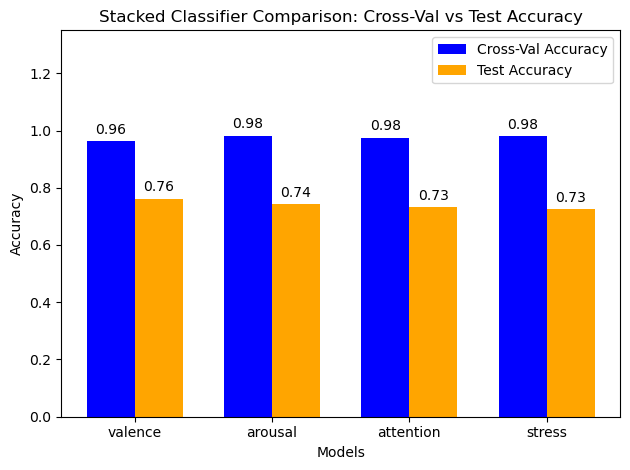

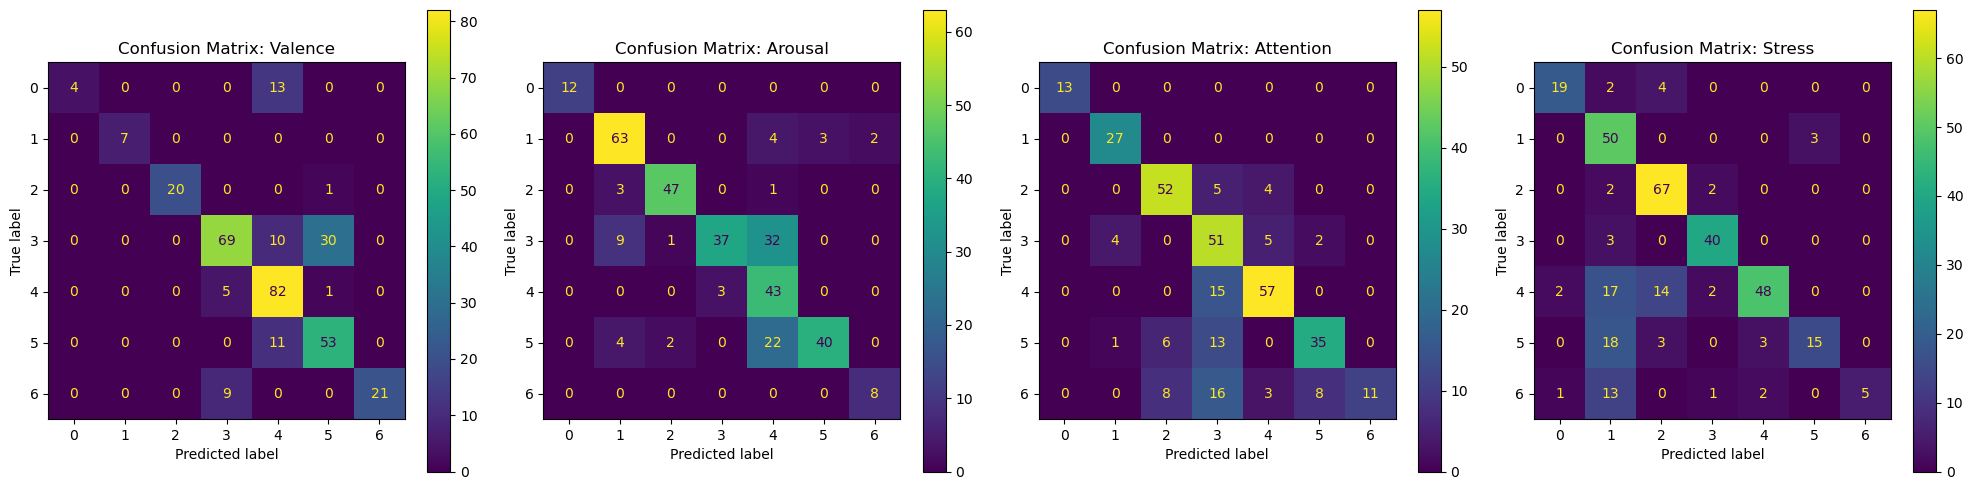

Cross-Val Accuracy: 0.974938251718213 += 0.014707028390860395
Cross-Val F1: 0.974104344106935 += 0.015613302244380994
Cross-Val Precision: 0.976749986699339 += 0.013525816640845633
Cross-Val Recall: 0.974938251718213 += 0.014707028390860395
Cross-Val AUC: 0.9982152137859654 += 0.00212916609691383
Test Accuracy: 0.7410714285714286
Test F1: 0.7335756022534953
Test Precision: 0.8033509522566666
Test Recall: 0.7410714285714286
Test AUC: 0.9549813740815289
Ideal Parameters {}


In [16]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

stacking_train_acc = []
stacking_test_acc = []
stacking_metrics = []
stacking_cms = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    estimators = [
        ("rf", rf_model),
        ("nb", nb_model),
        ("gb", gb_model),
        ("ada", ada_model),        
    ]    
    stacking_model = StackingClassifier(
        estimators=estimators, final_estimator=LogisticRegression()
    )
    
    param_grid = {}
    
    grid_search = get_grid_search(stacking_model, param_grid)
    grid_search.fit(X_train, y_train[target])
    
    test_preds = grid_search.best_estimator_.predict(X_test)
    stacking_model = grid_search.best_estimator_

    cv_metrics = get_grid_search_cv_metrics(grid_search, X_test, y_test[target])
    stacking_metrics.append(cv_metrics)

    stacking_cms.append(cv_metrics["test_cm"])

    stacking_train_acc.append(cv_metrics['crossval_accuracy'])
    stacking_test_acc.append(accuracy_score(y_test[target], test_preds))

plot_model_comparison("Stacked Classifier", y_columns, stacking_test_acc, stacking_train_acc)
plot_confusion_matricies(stacking_cms, y_columns)
print_cv_metrics(stacking_metrics)
print("Ideal Parameters", grid_search.best_params_)

**Neural Net**

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

inputs = layers.Input(shape=X_train.shape[1])

m = layers.Dense(256, activation='relu')(inputs)
m = layers.Dropout(0.2)(m)
m = layers.Dense(128, activation='relu')(m)
m = layers.Dropout(0.2)(m)
m = layers.Dense(64, activation='relu')(m)
m = layers.Dropout(0.2)(m)
m = layers.Dense(16, activation='relu')(m)

valence_output = layers.Dense(7, activation='softmax', name='valence')(m)
arousal_output = layers.Dense(7, activation='softmax', name='arousal')(m)
attention_output = layers.Dense(7, activation='softmax', name='attention')(m)
stress_output = layers.Dense(7, activation='softmax', name='stress')(m)

model = models.Model(inputs=inputs, outputs=[valence_output, arousal_output, attention_output, stress_output])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],

)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 26)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          6912        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 256)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 128)          32896       ['dropout[0][0]']                
                                                                                              

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Add 3 to convert to 0 to 6 instead of -3 to 3
y_train_valence = y_train['valence'].values + 3
y_train_arousal = y_train['arousal'].values + 3
y_train_attention = y_train['attention'].values + 3
y_train_stress = y_train['stress'].values + 3

y_test_valence = y_test['valence'].values + 3
y_test_arousal = y_test['arousal'].values + 3
y_test_attention = y_test['attention'].values + 3
y_test_stress = y_test['stress'].values + 3


In [19]:
from model_utils import plot_training_history

history = model.fit(
    X_train_scaled,
    {
        'valence': y_train_valence,
        'arousal': y_train_arousal,
        'attention': y_train_attention,
        'stress': y_train_stress
    },
    epochs=200,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/200
25/25 [==============================] - 2s 26ms/step - loss: 7.5526 - valence_loss: 1.8316 - arousal_loss: 1.9163 - attention_loss: 1.9117 - stress_loss: 1.8929 - valence_accuracy: 0.2984 - arousal_accuracy: 0.2584 - attention_accuracy: 0.1899 - stress_accuracy: 0.2468 - val_loss: 7.4354 - val_valence_loss: 1.7341 - val_arousal_loss: 1.9372 - val_attention_loss: 1.8438 - val_stress_loss: 1.9202 - val_valence_accuracy: 0.2680 - val_arousal_accuracy: 0.2629 - val_attention_accuracy: 0.2526 - val_stress_accuracy: 0.2371
Epoch 2/200
25/25 [==============================] - 0s 5ms/step - loss: 7.2858 - valence_loss: 1.7191 - arousal_loss: 1.8716 - attention_loss: 1.8595 - stress_loss: 1.8356 - valence_accuracy: 0.3088 - arousal_accuracy: 0.2519 - attention_accuracy: 0.2300 - stress_accuracy: 0.2674 - val_loss: 7.2147 - val_valence_loss: 1.7181 - val_arousal_loss: 1.8463 - val_attention_loss: 1.8108 - val_stress_loss: 1.8395 - val_valence_accuracy: 0.3093 - val_arousal_accuracy:

In [20]:
# plot_training_history(history=history)

31/31 [==============================] - 0s 950us/step


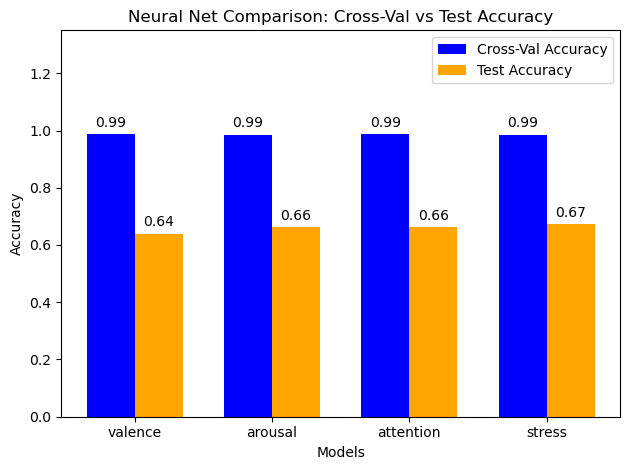

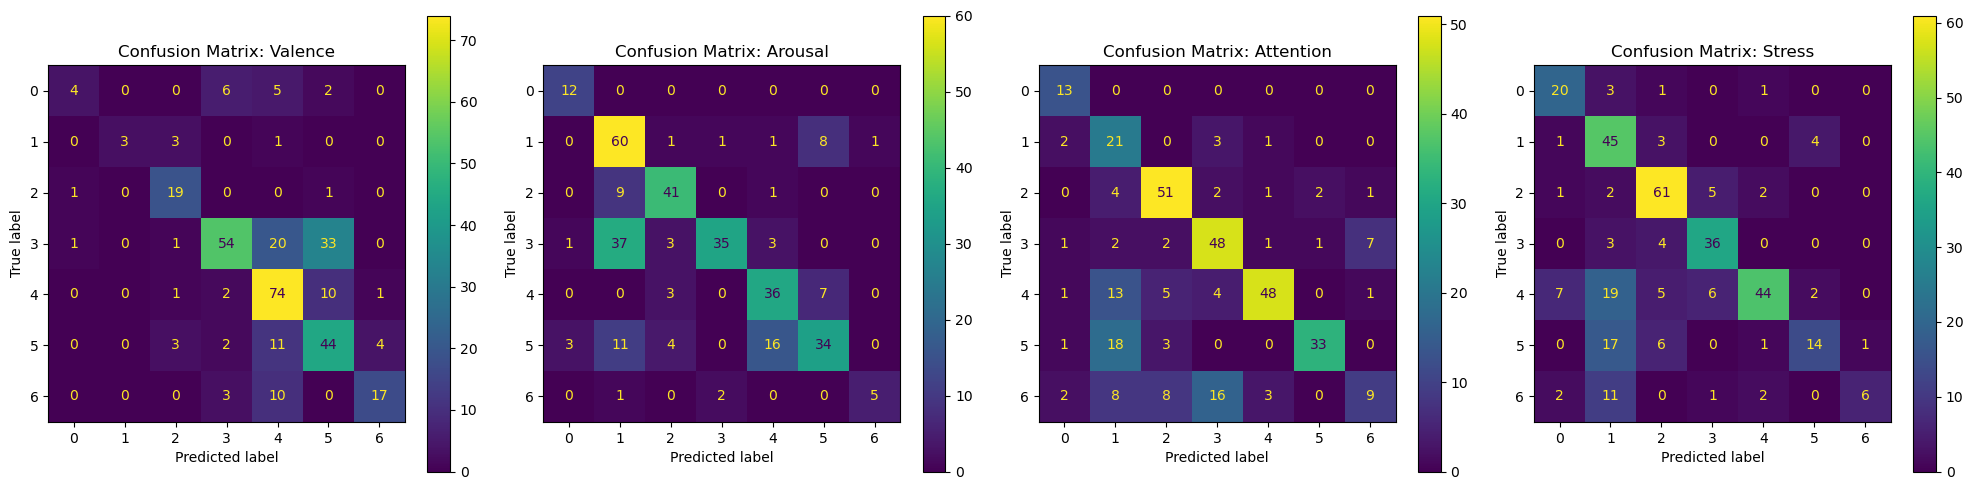

Average Train Accuracy 0.9860537190082644
Average Test Accuracy 0.6599702380952381
Average Train Precision 0.9862221982814944
Average Test Precision 0.7117663054417058
Average Train Recall 0.9860537190082644
Average Test Recall 0.6599702380952381
Average Train AUC 0.9986760761676999
Average Test AUC 0.9102265029306451
Average Train F1 0.9859573487183911
Average Test F1 0.6533962046248069


In [21]:
nn_train_acc = []
nn_test_acc = []
nn_metrics = []
nn_cms = []
# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    model.predict(X_test_scaled)

    # Subtract 3 to convert back to 0 to 6
    test_preds = np.argmax(model.predict(X_test_scaled)[i], axis=1) - 3
    train_preds = np.argmax(model.predict(X_train_scaled)[i], axis=1) - 3
    
    test_probs = model.predict(X_test_scaled)[i]
    train_probs = model.predict(X_train_scaled)[i]

    metrics = get_metrics(train_preds, y_train[target], test_preds, y_test[target], train_probs, test_probs)

    nn_train_acc.append(metrics["train_accuracy"])
    nn_test_acc.append(metrics["test_accuracy"])

    nn_cms.append(metrics["test_confusion_matrix"])

    nn_metrics.append(metrics)

plot_model_comparison("Neural Net", y_columns, nn_test_acc, nn_train_acc)
plot_confusion_matricies(nn_cms, y_columns)
print_averages(nn_metrics)

